- <a href="#acute_or_chronic">acute_or_chronic</a><br>
- <a href="#diagnoses">diagnosis</a><br>
- <a href="#labs">Labs</a><br>
- <a href="#pacemaker">pacemaker</a><br>
- <a href="#duration">duration</a><br>
- <a href="#"></a><br>

Load the data frame for EDA using %load Pipeline_clean.py

In [5]:
# %load Pipeline_clean.py
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from data_merge import *
from Clean_Fun import *

# NOTE have to use remove_invalid_rows() inside ALex's function,
# before we remove patient name
# %% Load dataset

live_path='Data/Cardiac Program_M.xlsx'
archive_path='Data/Cardiac Program_Archive.xlsx'
live_sheet_pkl='pickle_jar/live_sheets.pkl'
archive_sheet_pkl='pickle_jar/archive_sheets.pkl'
datecol_pkl='pickle_jar/datecols.pkl'
df = sheet_merge(live_path, archive_path,
    live_sheet_pkl, archive_sheet_pkl, datecol_pkl)
# %% test patients, determing Response Value

# NOTE have to remove invalid rows
df['outcome']=df.apply(lambda row: determine_outcome(row['status'],row['discharge'],row['discharge_date']),axis=1)
train_df,test_df=train_test_split_sg(df)
df=train_df.copy() # for now
del test_df

# %% Clean effusion rate

df['ef']=df['ef'].apply(lambda x: clean_EF_rows(x))

# Clean Blood Pressure rows
df['diastolic']=df.apply(lambda row: clean_diastolic_columns(
    row['diastolic'],row['resting_bp'],col_type='di'),axis=1)
df['systolic']=df.apply(lambda row: clean_diastolic_columns(
    row['systolic'],row['resting_bp'],col_type='sys'),axis=1)

# Dummify the diagnoses
uniq_diag=find_unique_diag(df.diagnosis_1)
dummy_df_diag=dummify_diagnoses(df,uniq_diag,diagnosis_col='diagnosis_1')
df.drop('diagnosis_1',axis=1,inplace=True)
dummy_df_diag.columns=pd.Series(uniq_diag).apply(lambda x: remove_paren(x)).append(pd.Series('enrollId'))
df=df.merge(dummy_df_diag,on='enrollId',how="inner")

# clean HR
df['resting_hr']=df.resting_hr.apply(lambda x: hand_dates(x))

# Clean Meds and aicd
# acute or chronic
med_aicd_clean(df,'ace', 0)
med_aicd_clean(df,'bb', 0)
med_aicd_clean(df,'diuretics', 0)
med_aicd_clean(df,'anticoagulant', 0)
med_aicd_clean(df,'ionotropes', 0)
med_aicd_clean(df,'aicd', 0)

# weight_dur_age_clean(df,dur_na=9999,age_na=9999,weight_perc_cutoff=0.2)
df['duration']=df.apply(lambda row: find_duration(row['discharge'],
    row['enrollment_date'],row['discharge_date']),axis=1)
df['age'] = df['date_of_birth'].apply(find_age)
df['weight_change_since_admit'] = df.apply(lambda row: clean_weight_change(
    row['weight'],row['weight_change_since_admit']),axis=1)

remove_invalid_rows(df)

df.loc[df['duration']==9999, 'duration'] = None
df.loc[df['age']==9999, 'age'] = None

# %%
pd.set_option('display.max_columns', 60)
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True, drop=True)
df.columns = [x.replace(" ", "_") for x in df.columns]
df = drop_date_cols(df)
df

df.to_csv('Data/clean_test.csv')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Live Sheet:
Sheet name: "patients"
Retained columns: ['patient_link', 'date_of_birth', 'patient_gender', 'ef', 'special_status']

Sheet name: "patient_enrollment_records"
Retained columns: ['patient_link', 'facilities_link', 'enrollment_date', 'hospital_discharged_from', 'admit_weight', 'diagnosis_1', 'acute_or_chronic', 'aicd', 'status', 'discharge', 'discharge_date', 'cardiac_related', 'create_user']

Sheet name: "patient weights"
Retained columns: ['patient_link', 'name', 'patient_weight_date', 'weight', 'this_weight_change', 'weight_change_since_admit']

Sheet name: "patient BNP"
Retained columns: ['patient_link', 'bnp_date', 'bnp', 'this_bnp_change']

Sheet name: "Cardiac_Meds"
Retained columns: ['patient_link', 'cardiac_meds_date', 'ace', 'bb', 'diuretics', 'anticoagulant', 'ionotropes', 'other cardiac meds']

Sheet name: "patient labs"
Retained columns: ['patient_link', 'labs_date', 'bun', 'c

num missing 223
value counts before zero and one assignment: 0                                                      223
lisinopril 5mg qd                                       25
none                                                    22
lisinopril 2.5mg qd                                     16
losartan 50mg qd                                        12
lisinopril 10mg qd                                       9
lisinopril 20mg qd                                       9
losartan 25mg qd                                         8
losartan 100mg qd                                        6
losartan potassium oral tablet 50 mg qd                  5
enalapril 5mg qd                                         5
enalapril 10mg qd                                        4
lisinopril                                               3
lisinopril 5mg bid                                       3
losartan 50mg                                            2
losartan potassium oral tablet 50 mg daily            

In [7]:
df.describe()

,ef,admit_weight,aicd,discharge,this_weight_change,weight_change_since_admit,this_bnp_change,ace,bb,diuretics,anticoagulant,ionotropes,resting_hr,outcome,cad/mi,heart_failure_unspecfied,diastolic_heart_failure,systolic_chf,atrial_fibrilation,cardiomyoapthy,lvad,chf,duration,age
count,308.000000,347.000000,430.000000,430.000000,430.000000,418.000000,418.000000,430.000000,430.000000,430.000000,430.000000,430.000000,422.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,410.000000,422.000000
mean,0.504189,167.081527,0.088372,0.995349,-0.716326,0.450215,-148.842105,0.423256,0.713953,0.630233,0.732558,0.086047,77.582938,0.555814,0.230233,0.274419,0.137209,0.313953,0.279070,0.053488,0.004651,0.002326,56.678049,75.753555
std,0.586967,56.036726,0.284166,0.068120,23.089995,11.876198,3284.662291,0.494651,0.452438,0.483304,0.443140,0.280759,11.240049,0.579688,0.421472,0.446741,0.344469,0.464638,0.449064,0.225267,0.068120,0.048224,342.632123,15.979527
min,0.100000,75.000000,0.000000,0.000000,-234.000000,-31.600000,-66618.000000,0.000000,0.000000,0.000000,0.000000,0.000000,51.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3638.000000,-28.000000
25%,0.350000,130.600000,0.000000,1.000000,-1.675000,-6.575000,-34.750000,0.000000,0.000000,0.000000,0.000000,0.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.000000,69.000000
50%,0.500000,155.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,77.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,47.500000,78.000000
75%,0.600000,189.700000,0.000000,1.000000,1.000000,4.750000,49.750000,1.000000,1.000000,1.000000,1.000000,0.000000,84.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,95.000000,87.000000
max,10.395000,498.000000,1.000000,1.000000,216.200000,44.000000,2580.000000,1.000000,1.000000,1.000000,1.000000,1.000000,120.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1390.000000,103.000000


In [6]:
df.shape

(430, 48)

<p><a name="acute_or_chronic"></a></p>
## acute_or_chronic

In [8]:
df.acute_or_chronic.value_counts(dropna=False)

Chronic    181
Acute      152
NaN         97
Name: acute_or_chronic, dtype: int64

A lot of missing. Not sure how to impute.

<p><a name="diagnoses"></a></p>
## Diagnoses

In [9]:
df.columns

Index(['patient_link', 'date_of_birth', 'patient_gender', 'ef',
       'special_status', 'facilities_link', 'hospital_discharged_from',
       'admit_weight', 'acute_or_chronic', 'aicd', 'status', 'discharge',
       'cardiac_related', 'create_user', 'enrollId', 'name', 'weight',
       'this_weight_change', 'weight_change_since_admit', 'bnp',
       'this_bnp_change', 'ace', 'bb', 'diuretics', 'anticoagulant',
       'ionotropes', 'other_cardiac_meds', 'bun', 'cr', 'sodium', 'potasium',
       'mg', 'this_cr_change', 'resting_hr', 'systolic', 'diastolic',
       'resting_bp', 'outcome', 'cad/mi', 'heart_failure_unspecfied',
       'diastolic_heart_failure', 'systolic_chf', 'atrial_fibrilation',
       'cardiomyoapthy', 'lvad', 'chf', 'duration', 'age'],
      dtype='object')

In [10]:
df.special_status.value_counts(dropna = False)

NaN              347
Death             47
NP Following      29
Collaboration      6
collaboration      1
Name: special_status, dtype: int64

In [11]:
df.status.value_counts(dropna = False)

To Home                     193
Hospital                    162
Death                        48
NaN                          19
Assisted Living Facility      5
No Reason Given               3
Name: status, dtype: int64

<p><a name="labs"></a></p>
## Labs

<p><a name="bnp"></a></p>
### BNP

In [89]:
df.bnp = pd.to_numeric(df.bnp)

Getting real tired of these mixed data types in all columns.

In [90]:
numericList = ['bnp']

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

(array([428.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([2.0000e+00, 6.8450e+03, 1.3688e+04, 2.0531e+04, 2.7374e+04,
        3.4217e+04, 4.1060e+04, 4.7903e+04, 5.4746e+04, 6.1589e+04,
        6.8432e+04]),
 <a list of 10 Patch objects>)

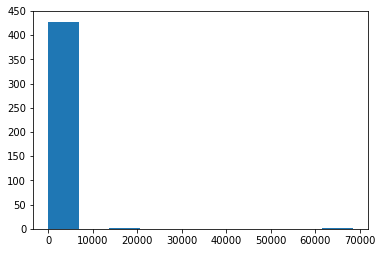

In [14]:
plt.hist(df.bnp.map(int))

Heavily skewed!

(array([  4.,  11.,  40.,  89., 111., 104.,  49.,  20.,   1.,   1.]),
 array([ 0.69314718,  1.73719205,  2.78123691,  3.82528178,  4.86932664,
         5.91337151,  6.95741637,  8.00146124,  9.0455061 , 10.08955097,
        11.13359583]),
 <a list of 10 Patch objects>)

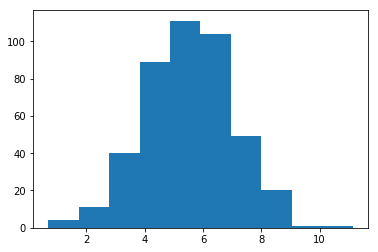

In [15]:
plt.hist(df.bnp.map(np.log))

log plot is much better! Box-Cox?

### this_bnp_change

In [19]:
df.this_bnp_change.isna().sum()

12

Few missing. Suggest imputing 0? Perhaps they only have one bnp measurement.

In [17]:
df.this_bnp_change.sort_values().head(10)

263   -66618.0
132    -2966.0
46     -2600.0
197    -1780.0
348    -1774.0
129    -1419.0
75     -1165.0
56     -1112.0
243    -1062.0
424     -940.0
Name: this_bnp_change, dtype: float64

-66618 bnp change is a ludicrous outlier

In [20]:
df.this_bnp_change.sort_values(ascending = False).head(10)

47     2580.0
369    1704.0
294    1556.0
358    1510.0
412    1439.0
164    1433.0
31     1188.0
320    1175.0
136    1107.0
371    1021.0
Name: this_bnp_change, dtype: float64

2580 is an outlier, but perhaps not rediculous.

(array([  2.,   3.,   6.,  11.,  79., 208.,  17.,   7.,   4.,   5.]),
 array([-1780. , -1431.6, -1083.2,  -734.8,  -386.4,   -38. ,   310.4,
          658.8,  1007.2,  1355.6,  1704. ]),
 <a list of 10 Patch objects>)

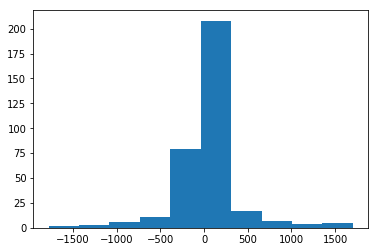

In [21]:
plt.hist(df.this_bnp_change.dropna()[(df.this_bnp_change > -2000)&(df.this_bnp_change != 0)&(df.this_bnp_change < 2000)])

## Meds

### Ace

In [25]:
df.ace.value_counts(dropna = False)

0.0    248
1.0    182
Name: ace, dtype: int64

### bb

In [26]:
df.bb.value_counts(dropna = False)

1.0    307
0.0    123
Name: bb, dtype: int64

### diuretics

In [27]:
df.diuretics.value_counts(dropna = False)

1.0    271
0.0    159
Name: diuretics, dtype: int64

### anticoagulant

In [28]:
df.anticoagulant.value_counts(dropna = False)

1.0    315
0.0    115
Name: anticoagulant, dtype: int64

### ionotropes

In [29]:
df.ionotropes.value_counts(dropna = False)

0.0    393
1.0     37
Name: ionotropes, dtype: int64

### other cardiac meds

In [30]:
df.other_cardiac_meds.value_counts(dropna = False)

NaN                                                                                                                                                                    172
Atorvastatin 40mg QD                                                                                                                                                    16
Atorvastatin 80mg QD                                                                                                                                                    13
Amlodipine 5mg QD                                                                                                                                                        8
Amlodipine 10mg QD                                                                                                                                                       7
Amiodarone 200mg QD                                                                                                                              

other cardiac meds column uncleaned?

## Labs

### bun

In [40]:
df.bun.isna().sum()

0

In [41]:
df.bun.describe()

count     430.0
unique     85.0
top        18.0
freq       23.0
Name: bun, dtype: float64

Format as numeric!

In [42]:
df.bun.map(float).describe()

count    430.000000
mean      35.723256
std       23.252845
min        0.000000
25%       19.000000
50%       29.000000
75%       46.000000
max      205.000000
Name: bun, dtype: float64

(array([130., 165.,  79.,  33.,  17.,   3.,   2.,   0.,   0.,   1.]),
 array([  0. ,  20.5,  41. ,  61.5,  82. , 102.5, 123. , 143.5, 164. ,
        184.5, 205. ]),
 <a list of 10 Patch objects>)

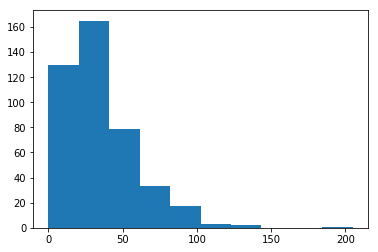

In [43]:
plt.hist(df.bun.dropna().map(int))

Skew.

In [44]:
(df.bun == 0).sum() 

1

Why the single 0 value? If imputed, I suggest changing the imputation to be the average.

(array([  1.,   0.,   0.,   0.,  29., 132., 133.,  97.,  35.,   3.]),
 array([0.        , 0.53278762, 1.06557523, 1.59836285, 2.13115047,
        2.66393808, 3.1967257 , 3.72951332, 4.26230094, 4.79508855,
        5.32787617]),
 <a list of 10 Patch objects>)

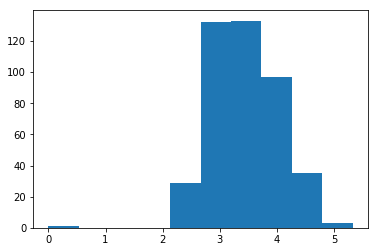

In [45]:
plt.hist((df.bun.map(int) + 1).map(np.log))

Log plot is better. Box-Cox?

### cr

In [46]:
df.cr.map(float).describe()

count    430.000000
mean       1.685535
std        1.537506
min        0.000000
25%        0.800000
50%        1.100000
75%        1.700000
max        9.100000
Name: cr, dtype: float64

Format as numeric

(array([147., 183.,  34.,  21.,  19.,   8.,   6.,   4.,   3.,   5.]),
 array([0.  , 0.91, 1.82, 2.73, 3.64, 4.55, 5.46, 6.37, 7.28, 8.19, 9.1 ]),
 <a list of 10 Patch objects>)

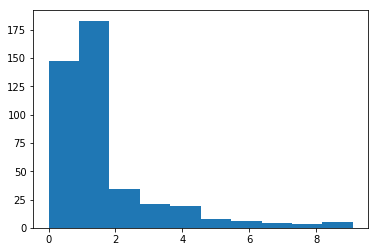

In [47]:
plt.hist(df.cr.dropna().map(float))

Skew!

In [50]:
(df.cr == 0).sum()

1

Why the single 0 value? If imputed, suggest changing to mean imputation.

(array([  1.,  23., 163., 109.,  47.,  34.,  14.,  20.,  10.,   9.]),
 array([0.        , 0.23125354, 0.46250708, 0.69376063, 0.92501417,
        1.15626771, 1.38752125, 1.6187748 , 1.85002834, 2.08128188,
        2.31253542]),
 <a list of 10 Patch objects>)

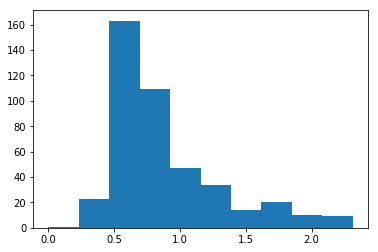

In [52]:
plt.hist((df.cr.dropna().map(float) + 1).map(np.log))

Log plot is better but still seems a bit skewed. Box-Cox?

### sodium

In [53]:
df.sodium.dropna().map(int).describe()

count    165.000000
mean     140.266667
std        4.880440
min      120.000000
25%      138.000000
50%      140.000000
75%      142.000000
max      164.000000
Name: sodium, dtype: float64

Format as integer!

In [54]:
df.sodium.isna().sum()

265

Loads of missing! How to impute?

(array([ 1.,  1.,  5., 33., 69., 41., 10.,  3.,  1.,  1.]),
 array([120. , 124.4, 128.8, 133.2, 137.6, 142. , 146.4, 150.8, 155.2,
        159.6, 164. ]),
 <a list of 10 Patch objects>)

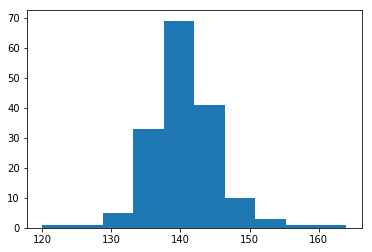

In [55]:
plt.hist(df.sodium.dropna().map(int))

Not bad.

### potasium

In [56]:
df.potasium.map(float).describe()

count    429.000000
mean       4.480653
std        1.091780
min        0.000000
25%        4.000000
50%        4.400000
75%        4.900000
max       22.300000
Name: potasium, dtype: float64

Format as float!

In [57]:
df.potasium.isna().sum()

1

Impute single missing value with mean?

(array([  2., 216., 208.,   2.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 0.  ,  2.23,  4.46,  6.69,  8.92, 11.15, 13.38, 15.61, 17.84,
        20.07, 22.3 ]),
 <a list of 10 Patch objects>)

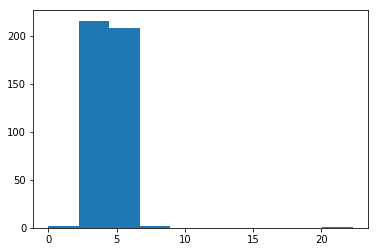

In [58]:
plt.hist(df.potasium.dropna().map(float))

Potential outlier

In [63]:
df.potasium.map(float).sort_values().head(5)

259    0.0
379    2.0
425    2.8
258    3.0
311    3.0
Name: potasium, dtype: float64

Single 0 value. Error? If imputed, suggest mean imputation.

In [64]:
df.potasium.map(float).sort_values().tail(5)

376     6.2
29      7.3
404     7.5
323    22.3
233     NaN
Name: potasium, dtype: float64

22.3 L value seems like crazy outlier? Treat as 2.3? Treat as missing?

### mg

In [65]:
df.mg.isna().sum()

43

A lot of missing!

(array([  6.,   0.,   7.,  21., 121., 155.,  51.,  11.,   8.,   7.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

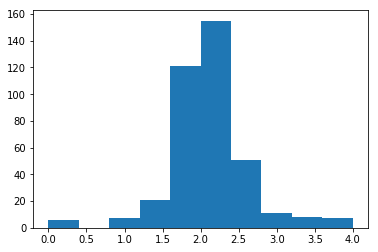

In [66]:
plt.hist(df.mg.dropna().map(float))

Not a bad plot

In [67]:
(df.mg == 0).sum()

6

Are these 0 values errors? Change to mean? There's a lot of missing already...

### this_cr_change

In [68]:
df.this_cr_change.isna().sum()

32

Significant missing values. Is there only a single cr measurement? If so impute 0?

(array([  1.,   2.,   3.,  11.,  39., 191., 116.,  23.,   3.,   9.]),
 array([-133.33 , -109.997,  -86.664,  -63.331,  -39.998,  -16.665,
           6.668,   30.001,   53.334,   76.667,  100.   ]),
 <a list of 10 Patch objects>)

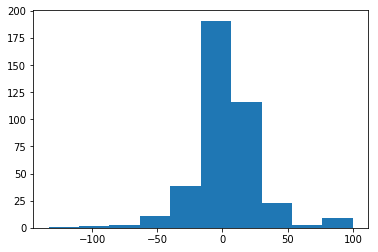

In [69]:
plt.hist(df.this_cr_change.dropna().map(float))

Looks OK.

<p><a name="pacemaker"></a></p>
## Pacemaker (aicd)

In [70]:
df.aicd.value_counts(dropna = False)

0.0    392
1.0     38
Name: aicd, dtype: int64

<p><a name="duration"></a></p>
## Duration

In [71]:
df.duration.describe()

count     410.000000
mean       56.678049
std       342.632123
min     -3638.000000
25%        24.000000
50%        47.500000
75%        95.000000
max      1390.000000
Name: duration, dtype: float64

In [75]:
df.duration.sort_values().head(21)

416   -3638.0
388   -2628.0
252   -1783.0
136   -1395.0
179   -1393.0
173   -1045.0
194   -1028.0
183   -1024.0
354    -997.0
110    -705.0
186    -696.0
175    -657.0
62     -334.0
86     -312.0
200    -307.0
251    -298.0
133    -277.0
207    -266.0
94      -27.0
132      -3.0
24        0.0
Name: duration, dtype: float64

Why all the negative durations?

In [92]:
df.duration.isna().sum()

20

20 missing durations.

In [78]:
df.duration[df.duration >= 0].describe()

count     390.000000
mean      107.823077
std       171.539564
min         0.000000
25%        26.250000
50%        49.000000
75%        98.000000
max      1390.000000
Name: duration, dtype: float64

(array([320.,  27.,  22.,  10.,   2.,   5.,   2.,   0.,   0.,   2.]),
 array([   0.,  139.,  278.,  417.,  556.,  695.,  834.,  973., 1112.,
        1251., 1390.]),
 <a list of 10 Patch objects>)

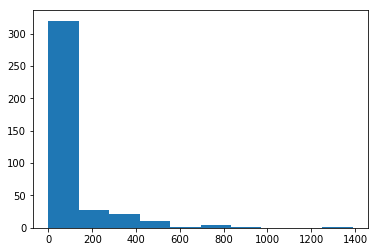

In [79]:
plt.hist(df.duration[(df.duration > -1 )])

Plot is heavily skewed.

(array([37., 37., 45., 41., 41., 35., 33., 17., 20., 19.]),
 array([ 1. , 10.8, 20.6, 30.4, 40.2, 50. , 59.8, 69.6, 79.4, 89.2, 99. ]),
 <a list of 10 Patch objects>)

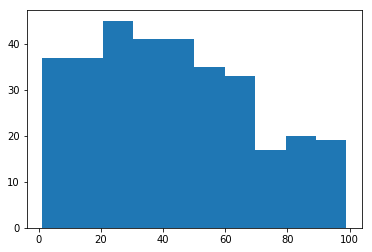

In [28]:
plt.hist(df.duration[(df.duration < 100)])

(array([  9.,   7.,  13.,  36.,  84., 132.,  72.,  42.,  26.,  11.]),
 array([0.        , 0.7237059 , 1.44741181, 2.17111771, 2.89482361,
        3.61852951, 4.34223542, 5.06594132, 5.78964722, 6.51335312,
        7.23705903]),
 <a list of 10 Patch objects>)

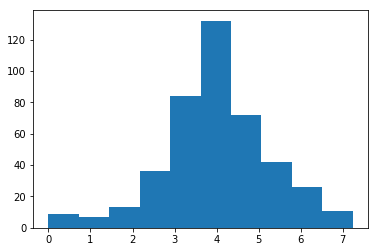

In [29]:
plt.hist(df.duration[df.duration < 9999].map(np.log))

Log histogram of non-missing values looks much more normal. Box-Cox transformation may be appropriate here.